In [1]:
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from lolip.utils import estimate_local_lip_v2
from params import mnistLip, cifarLip, svhnLip, mnistOtherLips, cifarOtherLips, svhnOtherLips
from params import noisyMnistLip
from utils import params_to_dataframe

TEX_DIR = "./tex_files"

auto_var.set_logging_level(0)

In [2]:
def get_model_name(model_name, hyper=None):
    if 'tulip' in model_name:
        return 7, 'GRv2'
    elif 'advkld' in model_name:
        return 7, 'AT(KLD)'
    elif 'advce' in model_name:
        return 8, 'AT(CE)'
    elif 'pstrades6' in model_name:
        return 21, 'PTRADE(6)'
    elif 'pstrades10' in model_name:
        return 22, 'PTRADE(10)'
    elif 'pstrades' in model_name:
        return 20, 'PTRADE(1)'
    elif 'strades6' in model_name:
        return 11, 'TRADE(6)'
    elif 'strades10' in model_name:
        return 12, 'TRADE(10)'
    elif 'strades' in model_name:
        return 10, 'TRADE(1)'
    elif 'ptrades6' in model_name:
        return 14, 'PTRADE(6/b)'
    elif 'ptrades10' in model_name:
        return 15, 'PTRADE(10/b)'
    elif 'ptrades' in model_name:
        return 13, 'PTRADE(1/b)'
    elif 'trades6' in model_name:
        return 24, 'TRADE(6/b)'
    elif 'trades10' in model_name:
        return 25, 'TRADE(10/b)'
    elif 'trades' in model_name:
        return 23, 'TRADE(1/b)'
    elif 'cure' in model_name:
        return 4, 'CURE'
    elif 'llr' in model_name:
        return 3, 'LLR'
    elif 'gr' in model_name:
        return 2, 'GR'
    elif 'kld' in model_name:
        return 1, 'Natural(kld)'
    else:
        return 0, 'Natural'
    
col_name = {
    'trn_acc': 'tr acc',
    'tst_acc': 'ts acc',
    'adv_trn_acc': 'adv tr acc',
    'adv_tst_acc': 'adv ts acc',
    'avg_trn_lip_kl': 'tr lip(KL)',
    'avg_tst_lip_kl': 'ts lip(KL)',
    'avg_trn_lip_1': 'tr lip(1)',
    'avg_tst_lip_1': 'ts lip(1)',
}

def output_latex(df):
    for name, d in df.groupby(["dataset", "arch"]):
        d = d.set_index('loss_name')
        d.index = [i[1] for i in d.index]
        d = d[['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']]
        d = d.rename(columns=col_name)
        d = d.sort_index(axis=0)
        tex = d.to_latex(index=True, float_format="%.4f", column_format="lccccccccc")
        with open(join(TEX_DIR, "_".join(name)+"_tab.tex"), "w") as f:
            f.write(tex)

def display_results(exp, otherExp=None):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip', 'avg_tst_lip']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir='./results/experiment01/',
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100
    if otherExp is not None:
        _, _, grid_params, _ = otherExp()()
        add_df = params_to_dataframe(grid_params,
                                 columns=['avg_trn_lip_1', 'avg_tst_lip_1', 'avg_trn_lip_kl', 'avg_tst_lip_kl'],
                                 result_file_dir='./results/experiment03/',
                                 logging_level=0)

        df = df.merge(add_df, how="left", on=['model', 'dataset', 'attack', 'norm', 'eps', 'random_seed'])
    else:
        df['avg_trn_lip_1'] = np.nan
        df['avg_tst_lip_1'] = np.nan
        df['avg_trn_lip_kl'] = np.nan
        df['avg_tst_lip_kl'] = np.nan

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))
    df['gen_gap'] = df['trn_acc'] - df['tst_acc']

    for name, d in df.groupby(["dataset", "arch"]):
        print(name)
        display(d)
    return df

In [6]:
df = display_results(mnistLip, mnistOtherLips)
output_latex(df)

('mnist', 'CNN001')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
0,pgd,mnist,0.1,strades6ce-tor-CNN001,inf,0,96.981667,97.07,88.558333,88.59,0.962375,0.964691,2.737411,2.752654,6.569613e-05,0.000069,CNN001,"(11, TRADE(6))",-0.088333
1,pgd,mnist,0.1,stradesce-tor-CNN001,inf,0,99.806667,99.26,96.150000,93.89,3.193482,3.239552,9.619464,9.690696,1.734590e-05,0.000060,CNN001,"(10, TRADE(1))",0.546667
2,pgd,mnist,0.1,tulipce-tor-CNN001,inf,0,99.988333,99.29,78.890000,76.80,9.883685,9.867259,26.081958,26.047614,5.060899e-05,0.000611,CNN001,"(7, GRv2)",0.698333
3,pgd,mnist,0.1,ce-tor-CNN001,inf,0,100.000000,99.20,40.813333,41.83,24.914808,25.083706,66.886009,67.246512,9.009926e-05,0.004028,CNN001,"(0, Natural)",0.800000
4,pgd,mnist,0.1,cure14ce-tor-CNN001,inf,0,100.000000,99.08,84.561667,84.27,4.352627,4.355541,12.549028,12.553495,2.296214e-07,0.000250,CNN001,"(4, CURE)",0.920000
5,pgd,mnist,0.1,advce-tor-CNN001,inf,0,99.981667,99.31,99.610000,96.17,2.771575,2.795055,8.730167,8.840337,6.501647e-07,0.000088,CNN001,"(8, AT(CE))",0.671667
6,pgd,mnist,0.1,llrce-tor-CNN001,inf,0,99.998333,99.34,86.045000,83.99,12.434842,12.424883,33.917080,34.063950,4.330360e-07,0.000391,CNN001,"(3, LLR)",0.658333
7,pgd,mnist,0.1,gr1e5ce-tor-CNN001,inf,0,99.998333,99.20,42.428333,43.01,23.387331,23.546093,61.804612,62.260961,4.416983e-05,0.003240,CNN001,"(2, GR)",0.798333


('mnist', 'CNN002')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
8,pgd,mnist,0.1,strades6ce-tor-CNN002,inf,0,99.613333,99.59,99.528333,98.72,0.471817,0.476693,1.351692,1.360831,-1.872465e-06,0.000001,CNN002,"(11, TRADE(6))",0.023333
9,pgd,mnist,0.1,stradesce-tor-CNN002,inf,0,99.963333,99.58,99.278333,96.94,1.719355,1.737225,4.687971,4.741066,4.780302e-08,0.000016,CNN002,"(10, TRADE(1))",0.383333
10,pgd,mnist,0.1,tulipce-tor-CNN002,inf,0,99.993333,99.55,95.711667,93.20,9.591815,9.538045,20.466134,20.264725,1.836552e-05,0.000269,CNN002,"(7, GRv2)",0.443333
11,pgd,mnist,0.1,ce-tor-CNN002,inf,0,100.000000,99.51,79.450000,80.53,9.913164,9.871323,23.046890,23.062061,5.872979e-06,0.000868,CNN002,"(0, Natural)",0.490000
12,pgd,mnist,0.1,cure14ce-tor-CNN002,inf,0,100.000000,99.50,93.298333,92.07,3.664297,3.655739,10.950875,10.931543,3.513807e-08,0.000100,CNN002,"(4, CURE)",0.500000
13,pgd,mnist,0.1,advce-tor-CNN002,inf,0,99.981667,99.48,99.838333,97.37,2.185941,2.200780,6.027635,6.090549,-7.070044e-08,0.000016,CNN002,"(8, AT(CE))",0.501667
14,pgd,mnist,0.1,llrce-tor-CNN002,inf,0,100.000000,99.58,96.180000,94.36,3.779049,3.814385,9.077055,9.068392,9.611180e-08,0.000073,CNN002,"(3, LLR)",0.420000
15,pgd,mnist,0.1,gr1e5ce-tor-CNN002,inf,0,100.000000,99.53,80.631667,80.58,9.060234,9.035110,20.325234,20.329833,9.180654e-07,0.000652,CNN002,"(2, GR)",0.470000


In [8]:
df = display_results(cifarLip, cifarOtherLips)
output_latex(df)

E0114 14:01:53.015810 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-scure14ce-tor-WRN_40_10-lrem2', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment01/pgd-cifar10-0.031-aug01-scure14ce-tor-WRN_40_10-lrem2-inf-0.pkl
problem with ./results/experiment01/pgd-cifar10-0.031-aug01-advce-tor-WRN_40_10-inf-0.pkl


E0114 14:01:53.254761 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-advce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}
E0114 14:01:53.416730 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-sllrce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment01/pgd-cifar10-0.031-aug01-sllrce-tor-WRN_40_10-inf-0.pkl


E0114 14:01:59.197704 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-tulipssem1ce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment03/pgd-cifar10-0.031-aug01-tulipssem1ce-tor-WRN_40_10-inf-0.pkl


E0114 14:02:00.883428 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-scure14ce-tor-WRN_40_10-lrem2', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment03/pgd-cifar10-0.031-aug01-scure14ce-tor-WRN_40_10-lrem2-inf-0.pkl


E0114 14:02:02.596534 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-advce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment03/pgd-cifar10-0.031-aug01-advce-tor-WRN_40_10-inf-0.pkl


E0114 14:02:03.515423 140693067130688 auto_var.py:341] Error with {'attack': 'pgd', 'dataset': 'cifar10', 'eps': 0.031, 'model': 'aug01-sllrce-tor-WRN_40_10', 'norm': 'inf', 'random_seed': 0}


problem with ./results/experiment03/pgd-cifar10-0.031-aug01-sllrce-tor-WRN_40_10-inf-0.pkl
('cifar10', 'WRN_40_10')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
0,pgd,cifar10,0.031,ce-tor-WRN_40_10,inf,0,100.000,88.62,0.000,6.81,103.132339,106.384285,347.441545,356.456262,6.014626e-02,5.258273,WRN_40_10,"(0, Natural)",11.380
1,pgd,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,99.714,71.68,21.910,13.27,9.704923,9.780603,NaN,NaN,NaN,NaN,WRN_40_10,"(7, GRv2)",28.034
2,pgd,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,99.794,78.34,99.752,37.27,3.580652,6.769163,11.143698,19.788508,9.408646e-06,0.083951,WRN_40_10,"(11, TRADE(6))",21.454
3,pgd,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,100.000,81.61,99.996,38.00,8.008823,10.167241,24.386368,30.786882,-1.715497e-06,0.086684,WRN_40_10,"(10, TRADE(1))",18.390
4,pgd,cifar10,0.031,cure14ce-tor-WRN_40_10,inf,0,92.862,74.83,8.292,7.23,8.511909,8.514249,19.157397,19.257976,8.709893e-02,0.101591,WRN_40_10,"(4, CURE)",18.032
5,pgd,cifar10,0.031,advce-tor-WRN_40_10,inf,0,99.982,74.00,99.694,33.08,5.454242,5.681854,16.087958,16.896749,1.665260e-04,0.042565,WRN_40_10,"(8, AT(CE))",25.982
6,pgd,cifar10,0.031,llrce-tor-WRN_40_10,inf,0,100.000,89.12,21.944,21.95,19.865181,21.330318,57.875086,61.140412,8.637365e-07,0.279248,WRN_40_10,"(3, LLR)",10.880


('cifar10', 'tor')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
7,pgd,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,100.000,93.81,0.002,0.00,121.004982,123.089828,418.622176,425.708713,0.261024,3.129502,tor,"(0, Natural)",6.190
8,pgd,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,94.904,80.74,22.376,18.62,8.595004,8.620595,NaN,NaN,NaN,NaN,tor,"(7, GRv2)",14.164
9,pgd,cifar10,0.031,aug01-strades6ce-tor-WRN_40_10,inf,0,98.928,84.46,91.232,48.57,3.137765,4.197079,10.059369,13.048935,0.000870,0.016461,tor,"(11, TRADE(6))",14.468
10,pgd,cifar10,0.031,aug01-stradesce-tor-WRN_40_10,inf,0,99.760,84.96,88.258,43.63,7.556588,8.372922,25.408692,28.009600,0.002134,0.043146,tor,"(10, TRADE(1))",14.800
11,pgd,cifar10,0.031,aug01-cure14ce-tor-WRN_40_10,inf,0,78.802,75.71,5.278,5.27,7.971639,7.990573,21.583233,21.616040,0.085902,0.087538,tor,"(4, CURE)",3.092
12,pgd,cifar10,0.031,aug01-advce-tor-WRN_40_10-bs256,inf,0,95.646,80.72,73.952,42.72,5.605396,5.635007,18.141732,18.352261,0.005212,0.015826,tor,"(8, AT(CE))",14.926
13,pgd,cifar10,0.031,aug01-llrce-tor-WRN_40_10,inf,0,100.000,92.48,19.684,17.87,21.750652,23.253151,65.973042,70.279050,0.000014,0.230248,tor,"(3, LLR)",7.520


In [5]:
df = display_results(svhnLip, svhnOtherLips)
output_latex(df)

('svhn', 'WRN_40_10')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
0,pgd,svhn,0.031,ce-tor-WRN_40_10,inf,0,0.999986,0.958474,0.034290,0.024700,48.150909,48.617779,149.078116,149.817892,0.045008,0.738318,WRN_40_10,"(0, Natural)",0.041512
1,pgd,svhn,0.031,strades6ce-tor-WRN_40_10,inf,0,0.971853,0.918331,0.819990,0.581131,1.166008,1.597083,3.849708,5.199245,0.001586,0.005057,WRN_40_10,"(11, TRADE(6))",0.053521
2,pgd,svhn,0.031,strades10ce-tor-WRN_40_10,inf,0,0.946299,0.903542,0.795419,0.575791,0.805747,1.146986,NaN,NaN,NaN,NaN,WRN_40_10,"(12, TRADE(10))",0.042757
3,pgd,svhn,0.031,curece-tor-WRN_40_10,inf,0,0.910029,0.907230,0.195585,0.190535,5.777227,5.557568,15.955604,15.261774,0.058604,0.055697,WRN_40_10,"(4, CURE)",0.002800
4,pgd,svhn,0.031,advce-tor-WRN_40_10-lrem2,inf,0,0.952005,0.924478,0.724682,0.550860,3.642485,3.780584,12.568644,13.025192,0.008108,0.013778,WRN_40_10,"(8, AT(CE))",0.027527
5,pgd,svhn,0.031,llrce-tor-WRN_40_10,inf,0,0.999973,0.951214,0.345632,0.306238,17.138792,18.932571,53.669503,59.484519,0.000012,0.183467,WRN_40_10,"(3, LLR)",0.048759


In [3]:
from scipy.special import softmax
def get_arch(path):
    return path.split("-")[path.split("-").index('tor')+1]

def get_ds(path):
    return path.split("-")[1]

def predict_real(model, X):
    X = X.transpose(0, 3, 1, 2)
    dataset = data_utils.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    ret = []
    for [x] in loader:
        ret.append(model(x.to('cuda')).detach().cpu().numpy())
    return np.concatenate(ret, axis=0)

def calc_lip(model, X, Xp, top_norm, btm_norm):
    top = np.linalg.norm(predict_real(model, X)-predict_real(model, Xp), ord=top_norm, axis=1)
    down = np.linalg.norm(X.reshape(len(Xp), -1)-Xp.reshape(len(Xp), -1), ord=btm_norm, axis=1)
    return top / (down+1e-6)

def get_lip(model, X, top_norm=2, btm_norm=2, epsilon=1.0):
    lip = estimate_local_lip_v2(model, X, top_norm=top_norm, btm_norm=btm_norm, epsilon=epsilon)
    lip_ = calc_lip(model, X, lip, top_norm=top_norm, btm_norm=btm_norm)
    return lip_

class ModelWrapper():
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        return softmax(predict_real(self.model, X), axis=1)
    def predict_real(self, X):
        return predict_real(self.model, X)
    def predict(self, X):
        return predict_real(self.model, X).argmax(axis=1)
    
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
model_path = "./models/pgd-cifar10-0.031-advce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

In [11]:
pred = model.predict_proba(trnX)
log_loss = np.array([np.log(pred[i][trny[i]]) for i in range(len(pred))])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+01,
        1.5000e+01, 2.2000e+01, 5.0000e+01, 8.7000e+01, 4.9811e+04]),
 array([-1.5260077 , -1.3734069 , -1.2208061 , -1.0682054 , -0.9156046 ,
        -0.7630038 , -0.61040306, -0.4578023 , -0.30520153, -0.15260077,
         0.        ], dtype=float32),
 <a list of 10 Patch objects>)

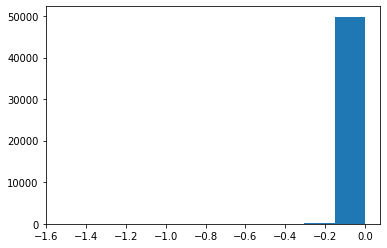

In [13]:
plt.hist(log_loss)

In [16]:
model_path = "./models/pgd-cifar10-0.031-strades6ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
pred = model.predict_proba(trnX)
log_loss2 = np.array([np.log(pred[i][trny[i]]) for i in range(len(pred))])

(array([   18.,   115.,   426.,  1486.,  4644.,  8722.,  4822., 12827.,
        10287.,  6653.]),
 array([-13.443183  , -12.117084  , -10.790984  ,  -9.464885  ,
         -8.138785  ,  -6.8126855 ,  -5.486586  ,  -4.1604867 ,
         -2.834387  ,  -1.5082875 ,  -0.18218805], dtype=float32),
 <a list of 10 Patch objects>)

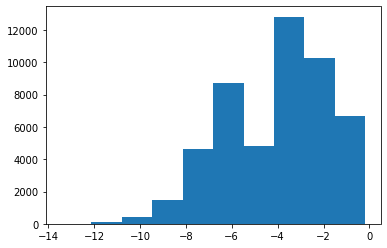

In [17]:
plt.hist(log_loss2)

In [4]:
from lolip.utils import estimate_local_mse
model_path = "./models/pgd-cifar10-0.031-aug01-ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
ret = estimate_local_mse(model, trnX[:100])
print(ret[0])

12.135422058105469


In [5]:
from lolip.utils import estimate_local_mse
model_path = "./models/pgd-cifar10-0.031-aug01-gr1e4ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
ret = estimate_local_mse(model, trnX[:100])
print(ret[0])

12.803192138671875


In [268]:
model_path = "./models/pgd-mnist-0.1-ce-tor-CNN002-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

In [280]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
n = 10000
i = 2
nb_iter=10
eps = 0.05
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(adv_tstX[:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

In [281]:
(pred.argmax(1) == tsty).mean()

0.9951

In [282]:
(advpred.argmax(1) == tsty).mean()

0.9484

In [274]:
robust = (advpred.argmax(1) == tsty)
np.where(np.logical_and(proba[robust] < 0.95, proba[robust] >0))
np.where(proba[robust] <= 0.99)

(array([], dtype=int64),)

In [265]:
proba[robust]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [257]:
np.where(correct)[0][117]

1482

In [270]:
print(sorted([(p, i) for i, p in enumerate(proba)])[::-1][-100:])

[(0.97487134, 5997), (0.97412044, 6400), (0.97044486, 1299), (0.97031534, 8325), (0.97002757, 4571), (0.96796405, 2414), (0.9637031, 5634), (0.96196944, 2195), (0.9615806, 1226), (0.9583196, 2742), (0.95528656, 5201), (0.95127004, 4743), (0.94789404, 3559), (0.94345146, 8246), (0.93751746, 1522), (0.9320616, 6173), (0.9306014, 3441), (0.93056595, 450), (0.91929656, 6560), (0.9192738, 2720), (0.9174346, 9015), (0.90024596, 1182), (0.89951736, 716), (0.8991391, 445), (0.88419014, 340), (0.87735033, 2921), (0.87473536, 447), (0.8679314, 2129), (0.8668577, 2369), (0.8641693, 6651), (0.8543442, 9692), (0.85244143, 2070), (0.85155416, 115), (0.849741, 8527), (0.8376695, 1039), (0.8313084, 3727), (0.82303584, 829), (0.8223893, 3853), (0.8061314, 4284), (0.7674289, 5749), (0.7514165, 6625), (0.7208942, 582), (0.719863, 2314), (0.71396136, 9839), (0.71158767, 1393), (0.6905592, 6572), (0.67504376, 551), (0.62629986, 4823), (0.6142822, 4504), (0.49901107, 9679), (0.47881937, 1737), (0.3323425, 2

In [212]:
print(sorted([(p, i) for i, p in enumerate(advproba)])[::-1])

[(1.0, 56), (4.4828436e-11, 19), (1.3591169e-15, 48), (8.946531e-21, 10), (2.2604156e-21, 13), (1.1726429e-22, 0), (1.1739716e-23, 69), (4.1126709e-25, 17), (3.1557007e-25, 77), (2.7697353e-25, 8), (1.19499354e-26, 87), (6.2973175e-27, 71), (6.8695745e-28, 31), (4.2315117e-28, 55), (1.056405e-28, 3), (6.9575236e-29, 82), (6.510607e-29, 1), (3.1628894e-29, 83), (4.020948e-30, 25), (1.2907183e-31, 27), (8.524556e-32, 22), (5.066804e-32, 51), (1.7231304e-32, 90), (1.5467976e-32, 70), (1.00739616e-32, 30), (1.0578339e-33, 43), (7.3458727e-34, 35), (3.3874175e-34, 24), (2.4483497e-34, 86), (2.2316131e-34, 88), (1.6890013e-34, 74), (1.5932688e-34, 76), (8.682368e-35, 15), (2.4569468e-35, 38), (1.8190208e-35, 34), (1.3883007e-35, 49), (7.872429e-36, 95), (6.9625706e-36, 4), (2.9803417e-36, 44), (2.4875104e-36, 99), (5.785949e-37, 94), (3.8333342e-37, 68), (2.3415904e-37, 23), (1.3195095e-37, 26), (1.1820249e-37, 62), (2.414749e-38, 93), (1.9969548e-38, 5), (1.6091957e-38, 59), (5.817903e-39, 

W0106 15:42:14.924072 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true class: 8
prediction: 8, proba: 0.7208942174911499
prediction: 2, proba: 1.0


[]

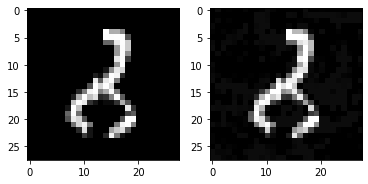

In [271]:
i=582
#i=78
print(f"true class: {int(tsty[i])}")
print(f"prediction: {int(pred.argmax(1)[i])}, proba: {pred.max(1)[i]}")
print(f"prediction: {int(advpred.argmax(1)[i])}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
f.add_subplot(1, 2, 2)
plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.plot()

NameError: name 'get_arch' is not defined

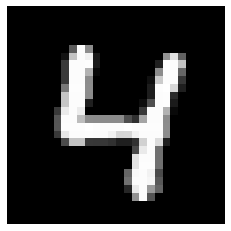

In [215]:
plt.axis('off')
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
#plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.savefig("./figs/mnist_img2.png", transparent=True)

In [122]:
model_path = "./models/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pkl")

In [123]:
n = 100
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(a['tst_lip_1_pert'][:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

print(sorted([(p, i) for i, p in enumerate(proba - advproba)])[::-1])
#print(proba)
#print(advproba)

[(0.91781914, 71), (0.7050022, 78), (0.627071, 87), (0.4679357, 20), (0.19889718, 10), (0.16712534, 47), (0.112924755, 49), (0.10954493, 81), (0.05335039, 85), (0.03948349, 91), (0.013468802, 22), (0.011327028, 32), (0.0032605529, 6), (0.0013139844, 53), (0.000441432, 7), (0.00015538931, 9), (4.0713585e-05, 58), (3.4332275e-05, 77), (5.722046e-06, 5), (3.8102835e-06, 24), (1.9073486e-06, 21), (1.4421756e-06, 35), (5.8958244e-07, 37), (0.0, 96), (0.0, 95), (0.0, 93), (0.0, 92), (0.0, 90), (0.0, 89), (0.0, 88), (0.0, 86), (0.0, 84), (0.0, 83), (0.0, 82), (0.0, 80), (0.0, 79), (0.0, 75), (0.0, 73), (0.0, 72), (0.0, 70), (0.0, 69), (0.0, 67), (0.0, 66), (0.0, 65), (0.0, 64), (0.0, 62), (0.0, 60), (0.0, 56), (0.0, 55), (0.0, 54), (0.0, 51), (0.0, 50), (0.0, 48), (0.0, 45), (0.0, 44), (0.0, 43), (0.0, 41), (0.0, 40), (0.0, 39), (0.0, 38), (0.0, 36), (0.0, 34), (0.0, 31), (0.0, 30), (0.0, 29), (0.0, 28), (0.0, 27), (0.0, 23), (0.0, 19), (0.0, 18), (0.0, 17), (0.0, 14), (0.0, 13), (0.0, 11), (

true class: cat
prediction: cat, proba: 0.9999980926513672
prediction: cat, proba: 0.9999980926513672


[]

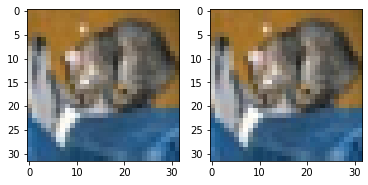

In [154]:
i=0
#i=78
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(pred.argmax(1)[i])]}, proba: {pred.max(1)[i]}")
print(f"prediction: {cifar_classes[int(advpred.argmax(1)[i])]}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(tstX[i])
f.add_subplot(1,2, 2)
plt.imshow(a['tst_lip_1_pert'][i])
plt.plot()

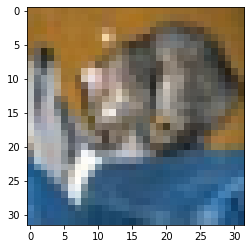

In [159]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
n = 200
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
predpro = model.predict_proba(tstX[:n])
advpro = model.predict_proba(adv_tstX[:n])
proba = np.array([predpro[i][tsty[i]] for i in range(n)])
advproba = np.array([advpro[i][tsty[i]] for i in range(n)])

In [168]:
print(sorted([(p, i) for i, p in enumerate(advproba)])[::-1])

[(3.928364e-19, 38), (2.139491e-20, 50), (6.2324763e-21, 67), (7.5909937e-22, 14), (5.8268816e-22, 11), (2.890054e-23, 56), (2.0332044e-24, 45), (5.753915e-25, 41), (3.278957e-25, 89), (1.7603159e-25, 44), (4.0502673e-26, 23), (3.8533094e-26, 47), (3.400378e-26, 96), (3.983777e-27, 19), (2.5159128e-27, 93), (1.2369445e-27, 95), (7.5774886e-28, 82), (1.7982877e-28, 6), (1.7919399e-28, 76), (7.5623535e-29, 28), (6.4600397e-29, 92), (2.8477258e-29, 13), (6.962432e-30, 62), (4.382583e-30, 98), (4.076206e-30, 39), (3.408397e-30, 79), (7.753089e-31, 60), (6.6937868e-31, 90), (6.2585087e-31, 37), (6.050055e-31, 88), (3.8625567e-31, 80), (3.3014763e-31, 34), (2.4592397e-31, 81), (2.066421e-31, 1), (1.6975366e-31, 40), (5.7094654e-32, 4), (1.2647153e-32, 73), (1.2139842e-32, 69), (1.09526326e-32, 15), (1.0822801e-32, 9), (7.681779e-33, 66), (7.1334875e-33, 33), (5.092126e-33, 71), (3.8350386e-33, 29), (2.8612442e-33, 27), (1.5129782e-33, 77), (1.3103929e-33, 20), (3.4747925e-34, 2), (2.4914444e

[[9.60847202e-31 1.00000000e+00 1.60442974e-27 8.66779592e-30
  5.83278945e-32 8.44278725e-22 7.71061711e-31 1.03557711e-28
  1.10328465e-33 8.09422565e-25]]
true class: ship
prediction: car, proba: 1.0


W0106 13:19:10.995937 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


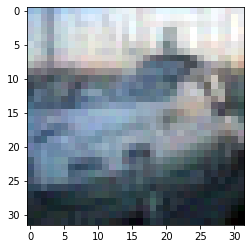

In [158]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)

adv_tstX = attack_model.perturb(tstX[i:i+1], tsty[i:i+1])
print(model.predict_proba(adv_tstX))
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(model.predict(adv_tstX)[0])]}, proba: {model.predict_proba(adv_tstX).max(1)[0]}")

plt.imshow(adv_tstX[0])

[[3.9642419e-13 4.6638211e-11 3.3105352e-10 3.0798118e-11 6.5500468e-01
  1.1840269e-06 1.5918528e-12 3.4499472e-01 5.9323409e-14 1.8311993e-11]]
prediction: deer, proba: 0.6550046801567078


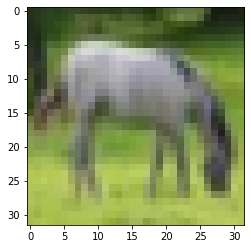

In [111]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
nb_iter=10
eps = 0.0035
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)

adv_trnX = attack_model.perturb(trnX[i:i+1], trny[i:i+1])
print(model.predict_proba(adv_trnX))
print(f"prediction: {cifar_classes[int(model.predict(adv_trnX)[0])]}, proba: {model.predict_proba(adv_trnX).max(1)[0]}")

plt.imshow(adv_trnX[0])
#adv_tstX = attack_model.perturb(tstX)
#print((ModelWrapper(model).predict(trnX) == trny).mean())
#print((ModelWrapper(model).predict(adv_trnX) == trny).mean())

In [25]:
Xs = []
for eps in [0.4, 0.6, 0.8, 1.0, 1.2]:
    Xs.append(estimate_local_lip_v2(model, trnX[:10], top_norm=1, btm_norm=np.inf, epsilon=eps))

(array([1.5200e+02, 6.5120e+03, 2.2573e+04, 2.0928e+04, 7.5230e+03,
        1.8900e+03, 3.4400e+02, 6.7000e+01, 8.0000e+00, 2.0000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.],
       dtype=float32),
 <a list of 10 Patch objects>)

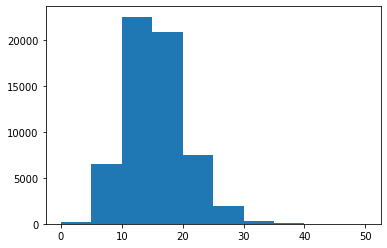

In [22]:
model_path = "./models/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pkl")
lip_ = calc_lip(model, trnX, a['trn_lip_1_pert'], top_norm=1, btm_norm=np.inf)
plt.hist(lip_, range=(0, 50))


[10.795519   9.563145   7.785195  ...  9.9654455  7.2449346 10.036863 ]


(array([5.3420e+03, 1.6160e+04, 1.9820e+04, 1.2501e+04, 4.6880e+03,
        1.1830e+03, 2.4400e+02, 5.1000e+01, 7.0000e+00, 4.0000e+00]),
 array([ 1.0522541,  4.1215   ,  7.190746 , 10.259992 , 13.329238 ,
        16.398483 , 19.46773  , 22.536976 , 25.60622  , 28.675467 ,
        31.744713 ], dtype=float32),
 <a list of 10 Patch objects>)

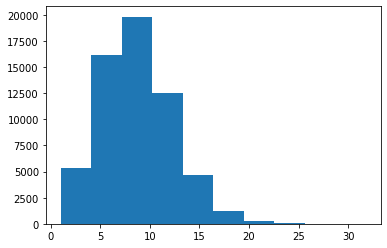

In [32]:
lip_ = get_lip(model, trnX)

0.0775341446240743


In [17]:
ModelWrapper(model).predict(trnX)

array([5, 0, 4, ..., 5, 6, 8])

In [16]:
a = joblib.load("results/experiment01/pgd-fashion-0.1-advce-tor-CNN002-inf-0.pkl")
a['history'][-5]


{'epoch': 156,
 'trn_loss': 0.4567526239236196,
 'trn_acc': 0.81165,
 'tst_loss': 0.3531107112646103,
 'tst_acc': 0.8642}

In [11]:
#a = joblib.load("./results/experiment01/pgd-fashion-0.1-advkld-tor-CNN002-inf-0.pkl")
a = joblib.load("./results/experiment01/pgd-svhn-0.031-advce-tor-WRN_40_10-lrem2-inf-0.pkl")
a['trn_acc']

0.9520045865924075

{'epoch': 1, 'trn_loss': 2545.292989117686, 'trn_acc': 0.9041, 'tst_loss': 0.055050141417980196, 'tst_acc': 0.9826}


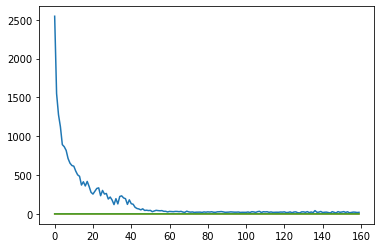

In [9]:
a = joblib.load("./results/experiment01/pgd-mnist-0.1-gr1e4ce-tor-CNN002-inf-0.pkl")
print(a['history'][0])
plt.plot([h['trn_loss'] for h in a['history']])
plt.plot([h['trn_acc'] for h in a['history']])
plt.plot([h['tst_acc'] for h in a['history']])

In [57]:
from scipy.special import kl_div

def kld(p, q):
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))

def trades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p)

def ptrades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p) / np.linalg.norm(p - advp, ord=np.inf)

def ce(p):
    return -np.log(p)

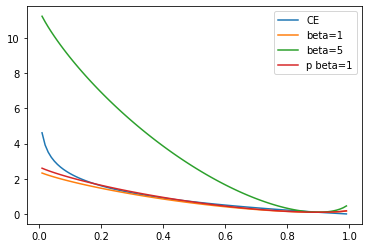

In [61]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.9, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.9, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.9, advp=advp, beta=1.0), label="p beta=1")
#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


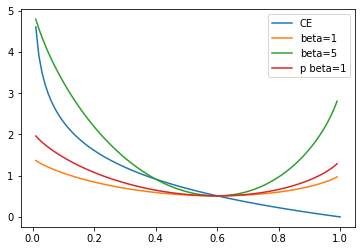

In [64]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.6, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.6, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.6, advp=advp, beta=1.0), label="p beta=1")

#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

In [ ]:
def plot_boundary(xx)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-1000-0.25")
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, architecture="MLP", epochs=60, learning_rate=1e-2)
_ = model.fit(trnX, trny, verbose=0)

In [7]:
trnX.shape
tstX.shape

(750,)